## 1.3. fMRI BASICS
**Purpose**:  Load NIfTI files, inspect shape and metadata, plotting mean functional images over a standard MNI152 template, visualize glass brain and examine indivisual volumes/stats


In [1]:
import os
import shutil
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting, image, datasets
from pathlib import Path

# Set up plotting style
%matplotlib inline

In [2]:
MNI_TEMPLATE = datasets.load_mni152_template()

### 1. Download or Load fMRI Data

**Dataset Overview**: The data used in this notebook is a preprocessed functional MRI (fMRI) dataset from a single subject, typically provided by the Nilearn development dataset.

- **Type**: 4D NIfTI image (3 spatial dimensions + 1 temporal dimension).
- **Signal**: Each voxel represents BOLD (blood-oxygen-level-dependent) signal intensity.
- **Space**: Compatible with MNI152 standard space.

In [3]:
repo_root = Path("./").resolve().parents[1] 
target_dir = repo_root / "datasets" / "fmri_sample"
data_path = target_dir / "sub-01_bold.nii.gz"

In [4]:
if not data_path.exists():
    print(f"Dataset not found. Downloading to {target_dir}...")
    target_dir.mkdir(parents=True, exist_ok=True)
    
    dev_data = datasets.fetch_development_fmri(n_subjects=1, data_dir=str(target_dir))
    shutil.copy(dev_data.func[0], str(data_path))

In [5]:
fmri_img = nib.load(str(data_path))
print(f"Successfully loaded fMRI image from: {data_path}")

Successfully loaded fMRI image from: /Users/yibeisita/Documents/neuro-ai-playground/datasets/fmri_sample/sub-01_bold.nii.gz


### 2. Inspect the Dimensions and Metadata
What is in this fMRI dataset?

- 3D + time NIfTI image (`4D`): (X, Y, Z, Time)
- Each voxel represents a small volume of brain tissue.
- Values represent **BOLD signal intensity** over time.
- This sample dataset is small, suitable for demonstration and tutorial purposes.

In [6]:
# Inspect dimensions: (X, Y, Z, Time)
print(f"Data shape: {fmri_img.shape}")
print(f"Voxel sizes (mm): {fmri_img.header.get_zooms()[:3]}")
print(f"TR (Repetition Time): {fmri_img.header.get_zooms()[3]}s")

Data shape: (50, 59, 50, 168)
Voxel sizes (mm): (np.float32(4.0), np.float32(4.0), np.float32(4.0))
TR (Repetition Time): 1.0s


In [7]:
# Display affine (mapping voxels to MNI space)
print("\nAffine Matrix:")
print(fmri_img.affine)


Affine Matrix:
[[   4.    0.    0.  -96.]
 [   0.    4.    0. -132.]
 [   0.    0.    4.  -78.]
 [   0.    0.    0.    1.]]


### 3. Plot mean functional image
- We compute the **mean across time** to get a static view of the brain.
- This provides a structural overview of the brain’s anatomy captured during fMRI acquisition.



In [8]:
# Compute mean across time
mean_fmri = image.mean_img(fmri_img)


/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_4028/2003271440.py:2: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_fmri = image.mean_img(fmri_img)


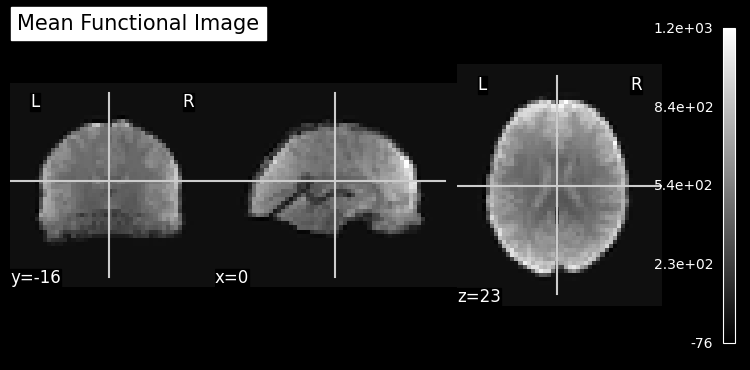

In [9]:
# Plot using nilearn's EPI visualizer
plotting.plot_epi(
        mean_fmri, 
        bg_img=MNI_TEMPLATE,
        title="Mean Functional Image", 
        display_mode="ortho", 
        colorbar=True, 
        draw_cross=True
)

plt.show()

### 4. Glass Brain Visualization
The Glass Brain provides a transparent view of the brain volume, which is essential for identifying the spatial extent of signals.

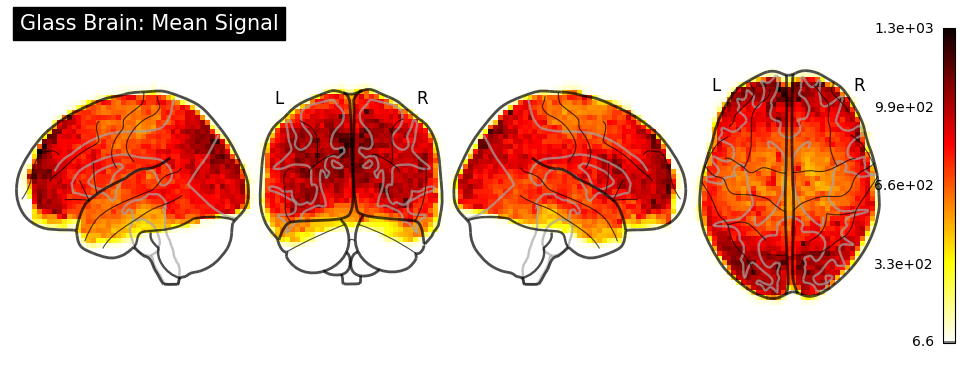

In [10]:
plotting.plot_glass_brain(mean_fmri, title="Glass Brain: Mean Signal", display_mode="lyrz", colorbar=True)
plt.show()

### 5. Examine Deviation-from-Mean fMRI Plots

Instead of looking at raw signal values, we subtract the mean image from specific volumes to see how the signal fluctuates at different timepoints.

- Each plot shows **how the BOLD signal at a specific timepoint deviates from the mean across all timepoints**.  
- **Positive values (warm colors)** indicate voxels with higher-than-average activity at that time.  
- **Negative values (cool colors)** indicate voxels with lower-than-average activity.  
- The **threshold and diverging colormap** help highlight meaningful deviations, making small variations more visible.  
- Note that these are **raw signal deviations**, not statistical activations; subtle changes may reflect noise or physiological fluctuations.  
- These visualizations help you **identify temporal dynamics** in the fMRI signal and understand which regions are transiently more or less active relative to the average.

In [11]:
data_array = fmri_img.get_fdata()
mean_data = np.mean(data_array, axis=-1)


In [12]:
timepoints = [0, 10, 20]

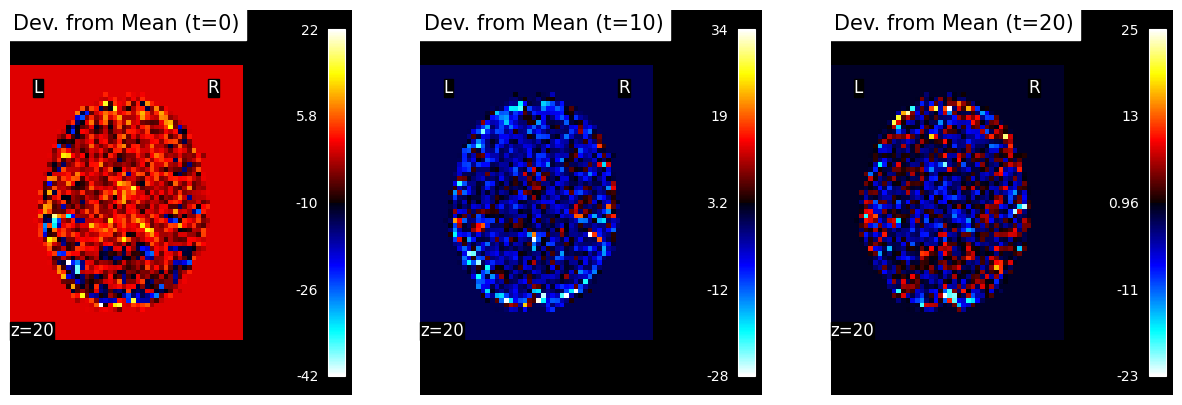

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, t in enumerate(timepoints):
    # Calculate Deviation: Current Volume - Mean Volume
    deviation_data = data_array[..., t] - mean_data
    
    # Wrap the result back into a Nifti object for plotting
    # We use the original affine to keep the spatial alignment
    dev_img = nib.Nifti1Image(deviation_data, fmri_img.affine)
    
    plotting.plot_epi(
        dev_img, 
        axes=axes[i], 
        display_mode="z", 
        cut_coords=[20], 
        title=f"Dev. from Mean (t={t})",
        cmap="cold_hot", # Blue for negative, Red for positive
        colorbar=True
    )

plt.show()